In [ ]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning
!pip install wldhx.yadisk-direct
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=74a147777398ea505160e911771c6162e07f88e75ea571f389c78d93b5113ef5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0b4b8a625da0f69e1caad57be08fb

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torchvision.transforms import Resize
from pprint import pprint
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/7Z8CzwJgKGYvvw) -o passport_dataset.zip
!unzip -qq passport_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  133M  100  133M    0     0  33.3M      0  0:00:04  0:00:04 --:--:-- 44.3M


In [ ]:
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

class PassportDataset(Dataset):
    def __init__(self, data_dir, labels_dir=''):

        self.XImg_list = []
        self.yLabel_list = []

        self.label_path = os.path.join(os.getcwd(), labels_dir)
        self.rgb_path = os.path.join(os.getcwd(), data_dir)
        self.XImg_list = sorted(os.listdir(self.rgb_path))
        self.yLabel_list = sorted(os.listdir(self.label_path))
        
    def __len__(self):
        length = len(self.XImg_list)
        return length

    def __getitem__(self, index):
        image = Image.open(f'{self.rgb_path}/{self.XImg_list[index]}')

        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        image = transforms.Resize((224, 224))(image)
        y = Image.open(f'{self.label_path}/{self.yLabel_list[index]}')
        y = transforms.PILToTensor()(y)
        y = transforms.Resize((224, 224))(y)
        y = y.type(torch.FloatTensor)
        y[y==255] = 1
        return image, y

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 224, 224]) torch.Size([1, 224, 224])


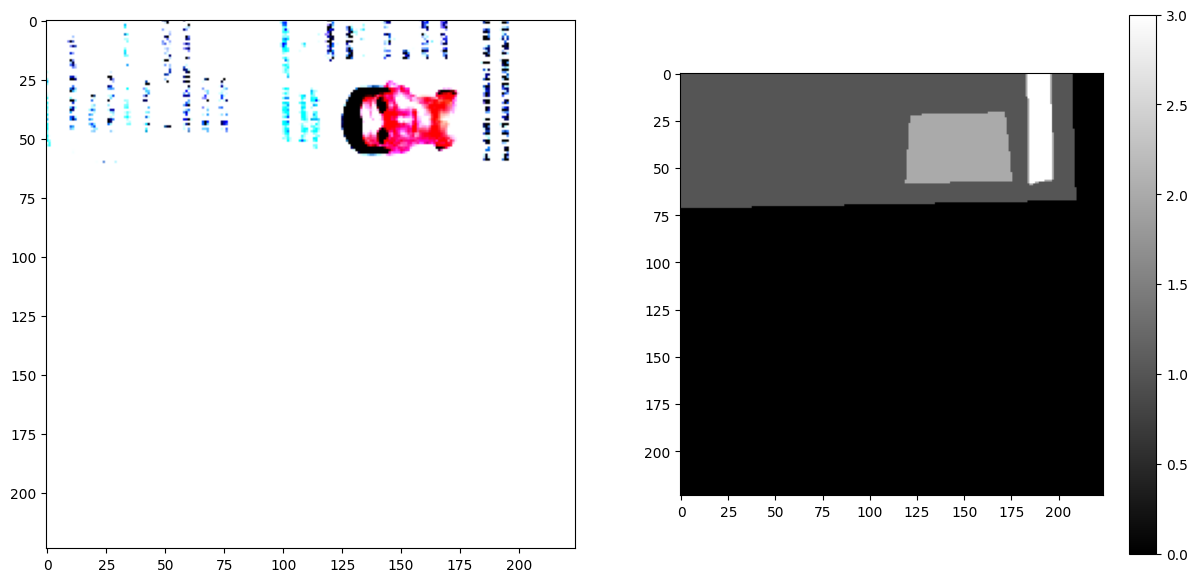

In [ ]:
dataset = PassportDataset('passport_dataset/data', 'passport_dataset/labels')
img, mask = dataset[10]

print(img.shape, mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
img = ax[1].imshow(mask.squeeze(0), cmap='gray')
plt.colorbar(img, ax=ax[1])
plt.show()

In [ ]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

g_cpu = torch.Generator().manual_seed(8888)
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size], generator=g_cpu)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)

In [ ]:
val_loader
train_loader

In [ ]:
val_size

173

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as metrics
import pytorch_lightning as pl
import segmentation_models_pytorch as smp


class PassportModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch[0]
        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]
        assert mask.ndim == 4
        mask = mask.squeeze(dim=1)
        logits_mask = self.forward(image)

        loss = self.loss_fn(logits_mask, mask.to(torch.long))

        pred_mask = logits_mask.argmax(dim=1)
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="multiclass", num_classes=4)
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)


In [63]:
model = PassportModel("FPN", "resnet34", in_channels=3, out_classes=4)

model = model.to(device)
trainer = pl.Trainer(
    max_epochs=20,
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | model   | FPN              | 23.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.623    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [67]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)
pprint(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.8836241960525513,
  'valid_per_image_iou': 0.8876073956489563}]


In [ ]:
batch = next(iter(val_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
    prob_mask = logits.sigmoid()
    pr_masks = (prob_mask > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().transpose(1, 2, 0)) 
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().transpose(1, 2, 0))
    plt.title("Prediction")
    plt.axis("off")

    plt.show()